In [28]:
#------Imports----------------------------

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
import xgboost as xgb


In [31]:
#------Data Preprocessing-----------------
#The dataset comprises X-ray Diffraction (XRD) spectra of calcium carbonate (CaCO3)

'The dataset comprises X-ray Diffraction (XRD) spectra of calcium carbonate (CaCO3) '

In [32]:
# .xlxs file contains the percentage of Calcite (target variable) and the other minerals present. 
#file is read and converted to dataframe
targets = pd.read_excel('desktop/Mini Project/xrd_labels.xlsx') #(1680, 14)
targets.head

<bound method NDFrame.head of       serial_no        sample_id  Calcite [%]  Calcite_Magnesian [%]  \
0             1     Carbonates_1        28.18                  44.31   
1             2     Carbonates_2        84.74                  14.52   
2             3     Carbonates_3        72.14                  26.59   
3             4     Carbonates_4        83.51                  16.02   
4             5     Carbonates_5        87.08                  12.46   
...         ...              ...          ...                    ...   
1675       1676  Carbonates_1676        86.52                  13.17   
1676       1677  Carbonates_1677        87.40                  12.19   
1677       1678  Carbonates_1678        87.14                  12.43   
1678       1679  Carbonates_1679        82.90                  16.61   
1679       1680  Carbonates_1680        82.91                  16.63   

      Vaterite [%]  Smithsonite [%]  Siderite [%]  Rhodochrosite [%]  \
0            13.46             0.

In [33]:
print("Minerals Present:")
print(targets.columns)

Minerals Present:
Index(['serial_no', 'sample_id', 'Calcite [%]', 'Calcite_Magnesian [%]',
       'Vaterite [%]', 'Smithsonite [%]', 'Siderite [%]', 'Rhodochrosite [%]',
       'Magnesite [%]', 'Monohydrocalcite [%]', 'Otavite [%]',
       'Clust ( Major Groupings)', 'Others [%]', 'Total Carbonates [%]'],
      dtype='object')


In [38]:
#The dataset includes 1680 .xy, files containing the diffractogram points for each sample
#The files were read and compiled into a single dataframe

headers = [row[0] for row in data]

df = pd.DataFrame()

for i in range(1, 1681):
    file_path = f'desktop/Mini Project/Data/xrd_data/Carbonates_{i}.xy'
    
    with open(file_path, 'r') as file:
        data = [list(map(float, line.split())) for line in file]
        second_column = [row[1] for row in data]
        temp_df = pd.DataFrame({f'Carbonates_{i}': second_column})
        df = pd.concat([df, temp_df], axis=1)

xrd_df = df.T #(1680, 6602)
xrd_df.columns = headers

xrd_df.to_csv('desktop/Mini Project/xrd_data.csv')

In [42]:
xrd_df0 = pd.read_csv('desktop/Mini Project/xrd_data.csv')
xrd_df = xrd_df0.iloc[:,1:] #(1680, 6602)
xrd_df.head

<bound method NDFrame.head of            4.0      4.01      4.02      4.03      4.04      4.05      4.06  \
0     1105.426  1102.672  1100.003  1097.504  1095.260  1093.357  1091.879   
1      652.162   647.369   643.948   642.851   638.393   640.878   644.338   
2      642.005   611.641   587.500   580.864   591.870   637.579   657.200   
3      493.000   482.355   472.746   467.665   474.093   497.480   513.607   
4      548.515   513.127   502.619   536.510   507.849   474.745   491.177   
...        ...       ...       ...       ...       ...       ...       ...   
1675   487.523   509.235   511.323   477.683   490.993   517.866   503.443   
1676   444.272   475.675   497.289   501.536   528.430   529.579   494.049   
1677   476.845   526.840   547.523   504.062   480.949   487.046   499.755   
1678   483.404   481.441   489.633   515.907   516.637   516.987   521.517   
1679   452.398   486.679   512.464   511.561   479.862   470.533   491.973   

          4.07      4.08      4.0

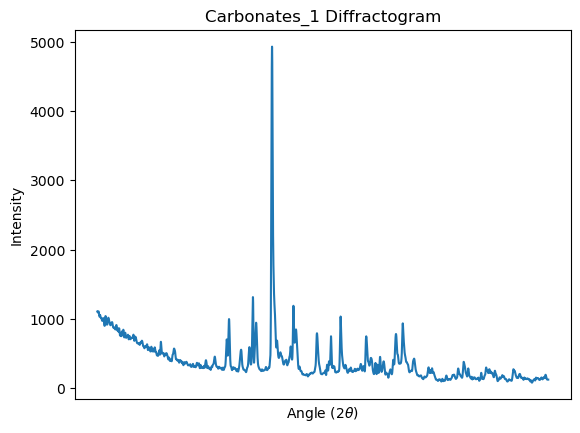

In [43]:
#Here we plot a sample diffractogram from the dataset
plt.plot(xrd_df.iloc[0])
plt.title('Carbonates_1 Diffractogram')
plt.xticks([])
plt.xlabel('Angle (2$\\theta$)')
plt.ylabel('Intensity')
plt.show()


In [44]:
print("\nxrd_df Information:")
print(xrd_df.info())

print("\nTargets Information:")
print(targets.info())


xrd_df Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Columns: 6602 entries, 4.0 to 70.01
dtypes: float64(6602)
memory usage: 84.6 MB
None

Targets Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   serial_no                 1680 non-null   int64  
 1   sample_id                 1680 non-null   object 
 2   Calcite [%]               1680 non-null   float64
 3   Calcite_Magnesian [%]     1680 non-null   float64
 4   Vaterite [%]              1680 non-null   float64
 5   Smithsonite [%]           1680 non-null   float64
 6   Siderite [%]              1680 non-null   float64
 7   Rhodochrosite [%]         1680 non-null   float64
 8   Magnesite [%]             1680 non-null   float64
 9   Monohydrocalcite [%]      1680 non-null   float64
 10  Otavite [%]               

In [45]:
#We selected a cutoff grade for good balance in the dataset.
#A new column is to differentiate samples that passes the set cutoff

cut_off = 80.00

targets['Cutoff Calcite'] = np.where(targets['Calcite [%]'] >= cut_off, 1, 0)

distribution = targets['Cutoff Calcite'].value_counts()

print(distribution)


Cutoff Calcite
0    862
1    818
Name: count, dtype: int64


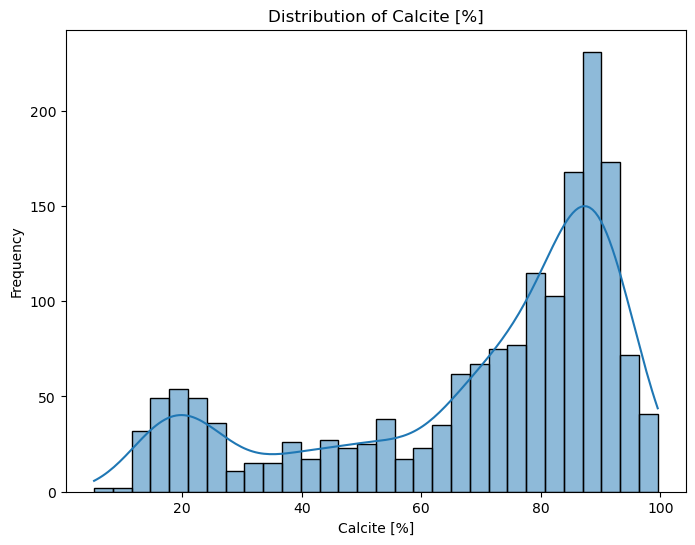

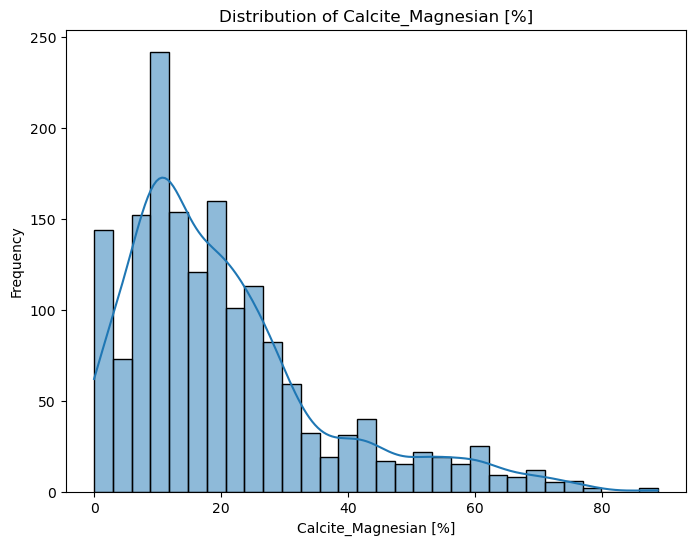

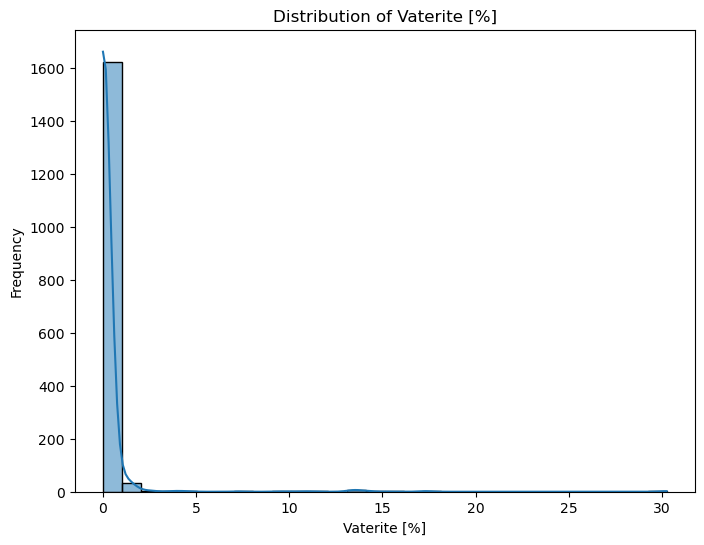

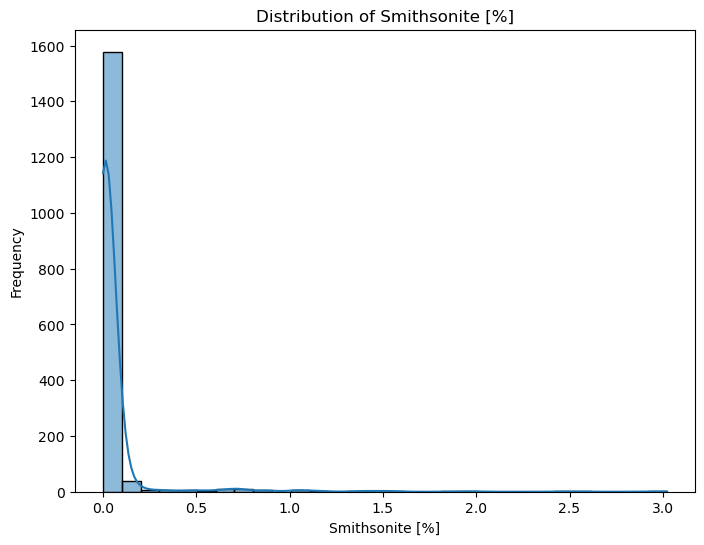

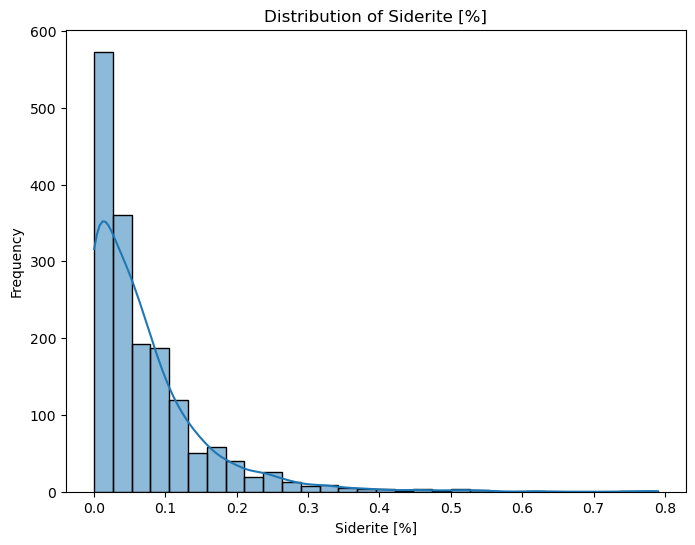

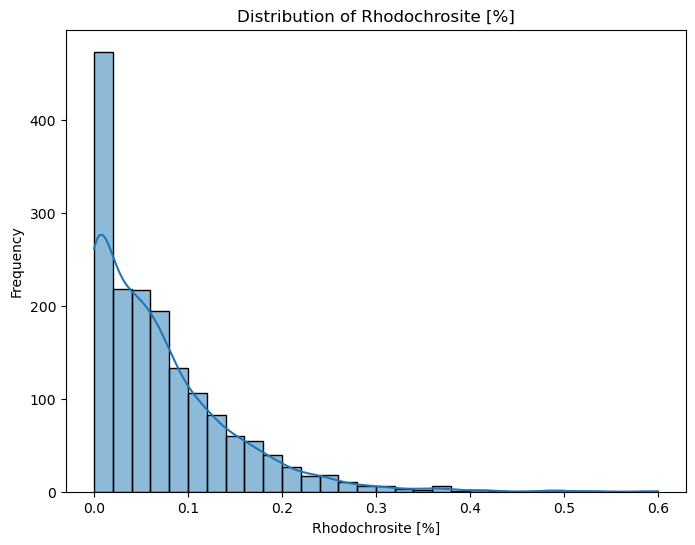

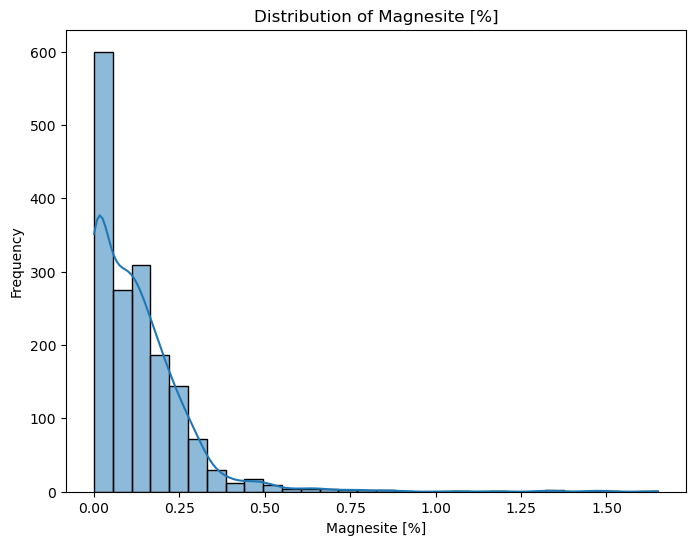

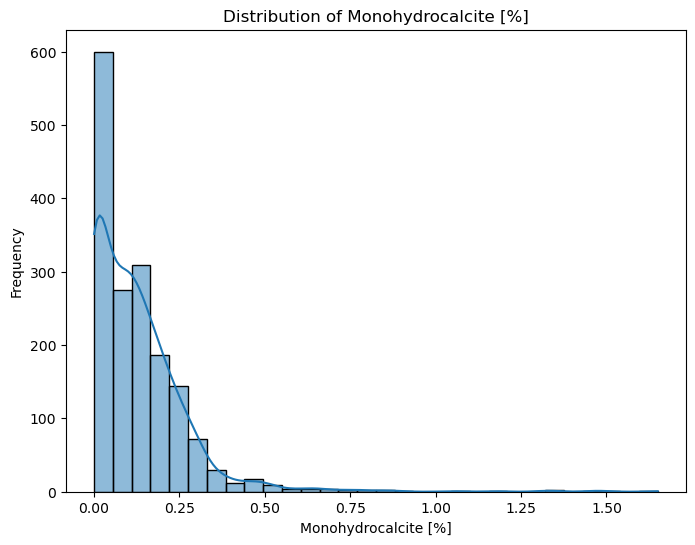

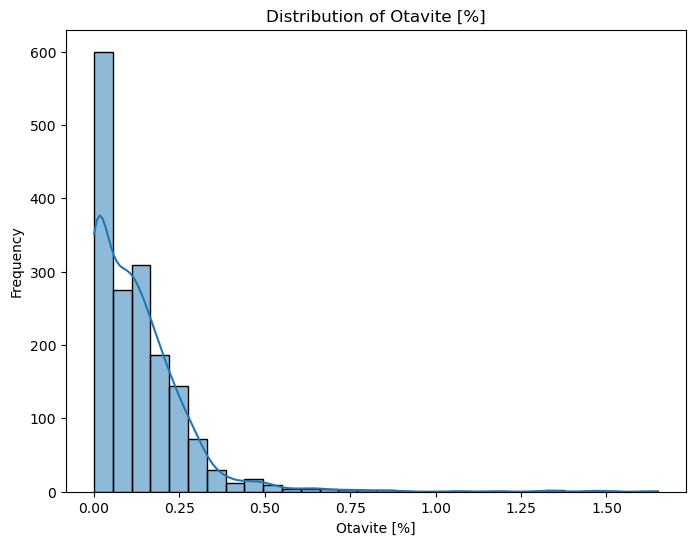

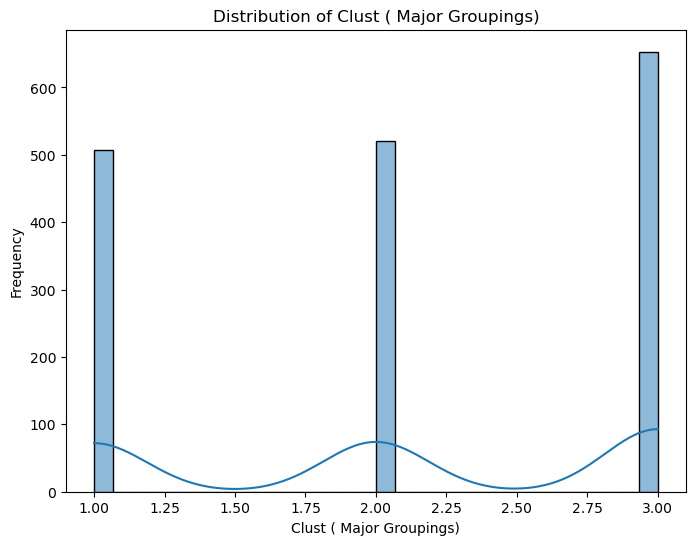

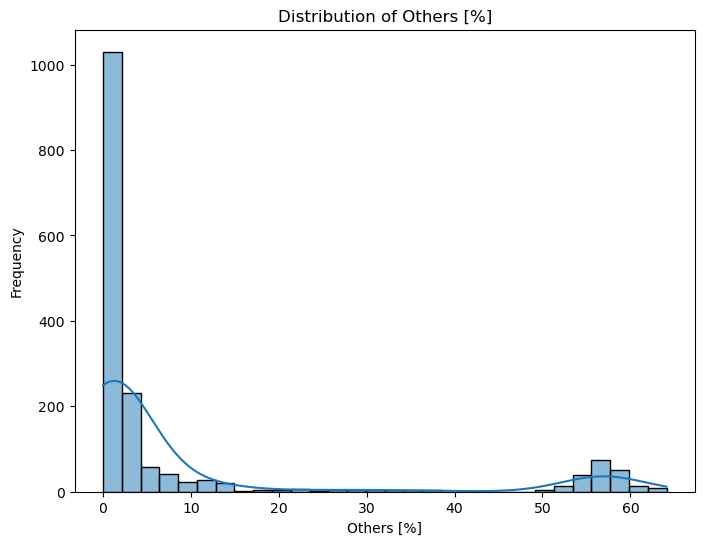

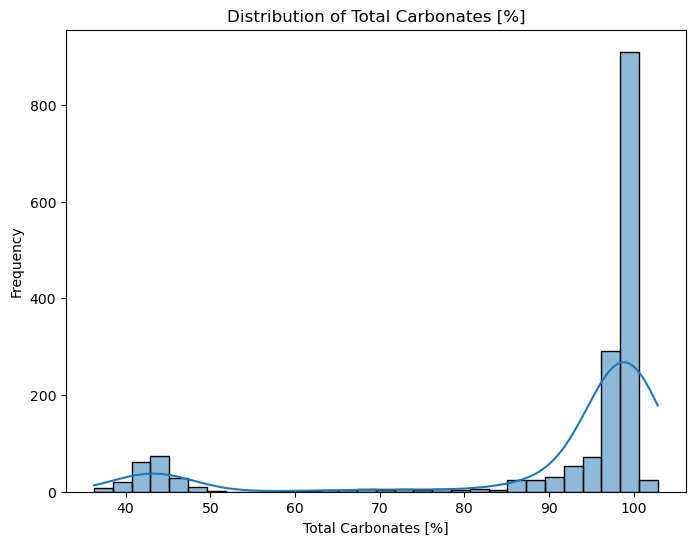

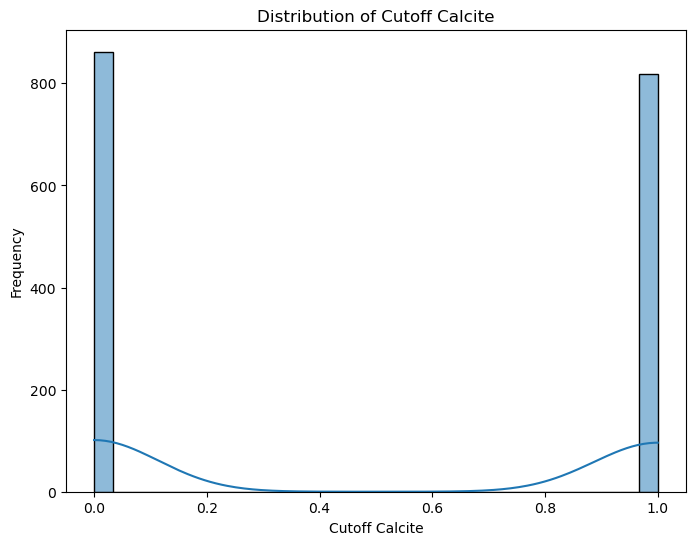

In [46]:
#Here we analyze the distribution of each mineral present
for column in targets.columns[2:]:
    plt.figure(figsize=(8, 6))
    sns.histplot(targets[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [12]:
#MODEL A: Use XGBOOST with arbitrarily chosen hyperparameters using all points.

In [47]:
%%time

X = xrd_df
y = targets['Cutoff Calcite']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(learning_rate=0.2, 
                    
                        max_depth=3,      
                        min_child_weight=5, 
                        gamma=2,        
                        objective='multi:softmax', 
                        num_class=len(set(y))
                       )


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 95.24%
Classification Report:
              precision    recall  f1-score   support

           0     0.9591    0.9480    0.9535       173
           1     0.9455    0.9571    0.9512       163

    accuracy                         0.9524       336
   macro avg     0.9523    0.9525    0.9524       336
weighted avg     0.9525    0.9524    0.9524       336

CPU times: total: 1min 3s
Wall time: 12.1 s


In [16]:
#We get the feature importance scores of each points/features
feature_importance = clf.feature_importances_

In [ ]:
#We train XGBOOST in each of the Top N [0,100] points without changing the hyperparameters

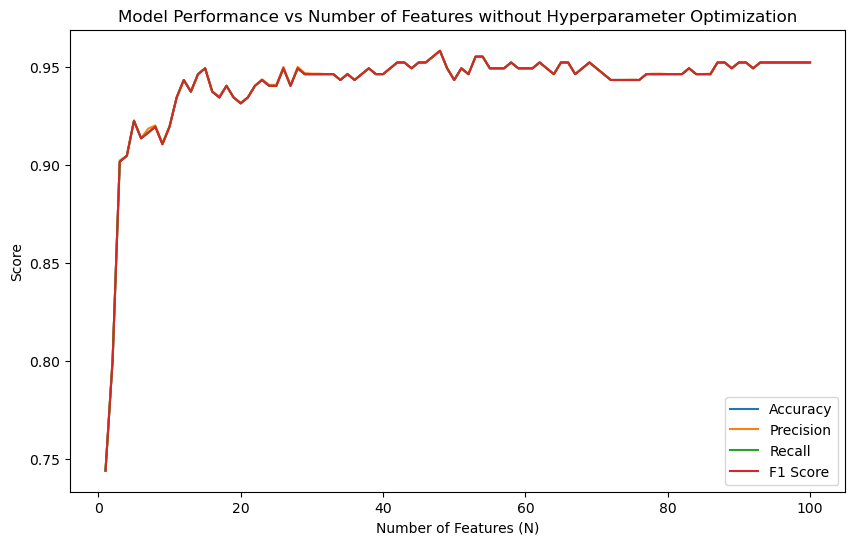

CPU times: total: 1min 6s
Wall time: 17 s


In [21]:
%%time

N_values = np.arange(1, 101) 

accuracy_values0 = []
precision_values0 = []
recall_values0 = []
f1_values0 = []

for N in N_values:

    top_N_indices = feature_importance.argsort()[-N:][::-1]
    X_top_N = X.iloc[:, top_N_indices]

    X_train, X_test, y_train, y_test = train_test_split(X_top_N, y, test_size=0.2, random_state=42)

    clf = xgb.XGBClassifier(learning_rate=0.2, 
       
                        max_depth=3,    
                        min_child_weight=5, 
                        gamma=2,         
                        objective='multi:softmax', 
                        num_class=len(set(y))
                       )

    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') 
    recall = recall_score(y_test, y_pred, average='weighted') 
    f1 = f1_score(y_test, y_pred, average='weighted')  

    accuracy_values0.append(accuracy)
    precision_values0.append(precision)
    recall_values0.append(recall)
    f1_values0.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(N_values, accuracy_values0, label='Accuracy')
plt.plot(N_values, precision_values0, label='Precision')
plt.plot(N_values, recall_values0, label='Recall')
plt.plot(N_values, f1_values0, label='F1 Score')

plt.xlabel('Number of Features (N)')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Features without Hyperparameter Optimization')
plt.legend()
plt.show()


In [22]:
#We select the number of points with the best result
max_acc_N1 = max(accuracy_values0)
N1 = accuracy_values0.index(max_acc_N1)

print("Maximum Accuracy:", max_acc_N1)
print("N1:", N1)


Maximum Accuracy: 0.9583333333333334
N1: 47


In [ ]:
#Model B: Use only the best 47 points to train XGBOOST. We use the same hyperparameters

In [23]:
%%time

top_47_indices = feature_importance.argsort()[-47:][::-1]
X_top_N = X.iloc[:, top_47_indices]

X_train, X_test, y_train, y_test = train_test_split(X_top_N, y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(learning_rate=0.2, 
              
                        max_depth=3,     
                        min_child_weight=5, 
                        gamma=2,        
                        objective='multi:softmax', 
                        num_class=len(set(y))
                       )


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 95.54%
Classification Report:
              precision    recall  f1-score   support

           0     0.9593    0.9538    0.9565       173
           1     0.9512    0.9571    0.9541       163

    accuracy                         0.9554       336
   macro avg     0.9553    0.9554    0.9553       336
weighted avg     0.9554    0.9554    0.9554       336

CPU times: total: 594 ms
Wall time: 167 ms


In [ ]:
#Hyperparameter optimization was performed on the XGBoost algorithm using grid search
#with 5-fold cross validation for each of the varying number of features (N ), ranging from 1 to 50. 

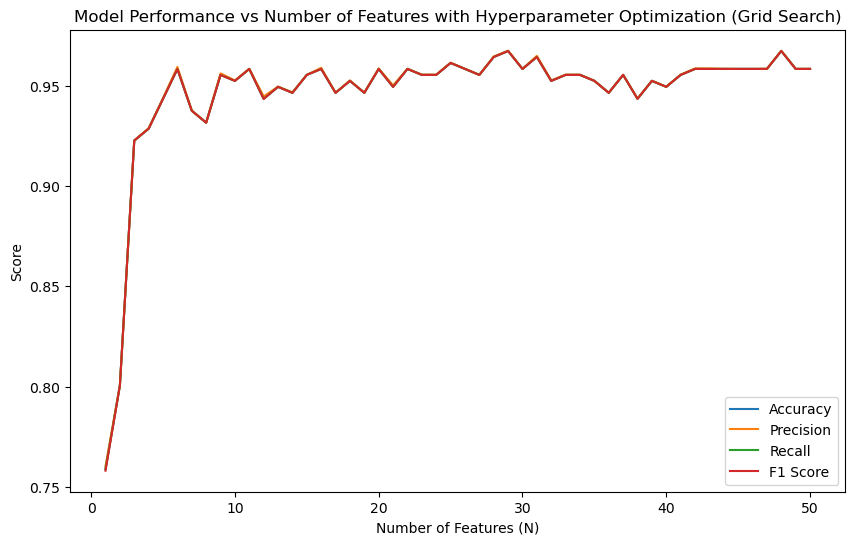

CPU times: total: 8min 7s
Wall time: 18min 38s


In [62]:
%%time

N_values = np.arange(1, 51) 

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

for N in N_values:

    top_N_indices = feature_importance.argsort()[-N:][::-1]
    X_top_N = X.iloc[:, top_N_indices]

    X_train, X_test, y_train, y_test = train_test_split(X_top_N, y, test_size=0.2, random_state=42)

    param_grid = {
        'eta': np.arange(0.01, 0.31, 0.1),  
        'max_depth': [0,1,2,3,4,5],
        'min_child_weight': [1,2,3,4,5],
        'gamma': [0,1,2,3,4,5],
    }

    clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)))

    grid_search = GridSearchCV(
        clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    optimized_clf = grid_search.best_estimator_
    optimized_clf.fit(X_train, y_train)

    y_pred = optimized_clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted') 
    f1 = f1_score(y_test, y_pred, average='weighted') 


    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(N_values, accuracy_values, label='Accuracy')
plt.plot(N_values, precision_values, label='Precision')
plt.plot(N_values, recall_values, label='Recall')
plt.plot(N_values, f1_values, label='F1 Score')

plt.xlabel('Number of Features (N)')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Features with Hyperparameter Optimization (Grid Search)')
plt.legend()
plt.show()


In [24]:
#We select the number of points with the best result
max_acc_N2 = max(accuracy_values)
N2 = accuracy_values0.index(max_acc_N2)

print("Maximum Accuracy:", max_acc_N2)
print("N2:", N2)


NameError: name 'accuracy_values' is not defined

In [ ]:
#Model C: Use N2 = 28 points to train XGBOOST. We do gridsearch to find the optimized hyperparameters

In [67]:
param_grid = {
    'learning_rate': np.arange(0.01, 0.31, 0.1),
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 1, 2, 3, 4, 5],
}

top_28_indices = feature_importance.argsort()[-28:][::-1]
X_top_N = X.iloc[:, top_28_indices]

X_train, X_test, y_train, y_test = train_test_split(X_top_N, y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)))

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

optimized_clf = grid_search.best_estimator_

y_pred = optimized_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Best Hyperparameters:")
print(grid_search.best_params_)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 96.43%
Best Hyperparameters:
{'gamma': 0, 'learning_rate': 0.21000000000000002, 'max_depth': 0, 'min_child_weight': 1}
Classification Report:
              precision    recall  f1-score   support

           0     0.9548    0.9769    0.9657       173
           1     0.9748    0.9509    0.9627       163

    accuracy                         0.9643       336
   macro avg     0.9648    0.9639    0.9642       336
weighted avg     0.9645    0.9643    0.9643       336



In [ ]:
#Plots

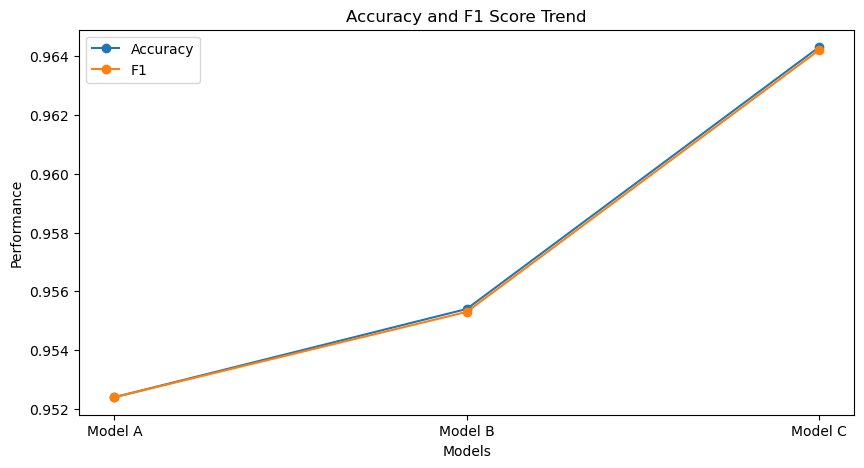

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(models, accuracy, marker='o', label='Accuracy')
plt.plot(models, f1, marker='o', label='F1')
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Accuracy and F1 Score Trend')
plt.legend()
plt.show()


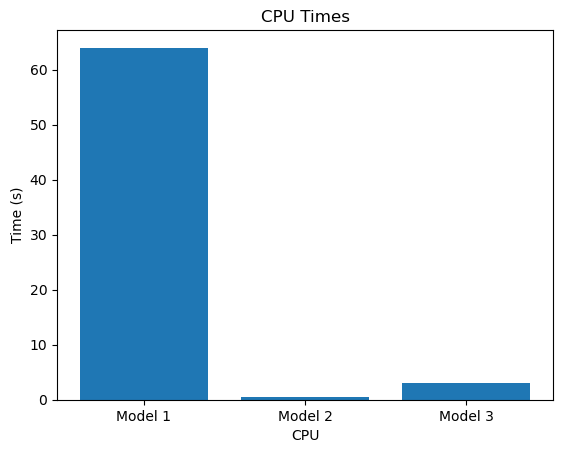

In [45]:
cpu_labels = ['Model 1', 'Model 2', 'Model 3']
cpu_times = [64, 0.562, 3.02]

plt.bar(cpu_labels, cpu_times)
plt.xlabel('CPU')
plt.ylabel('Time (s)')
plt.title('CPU Times')
plt.show()


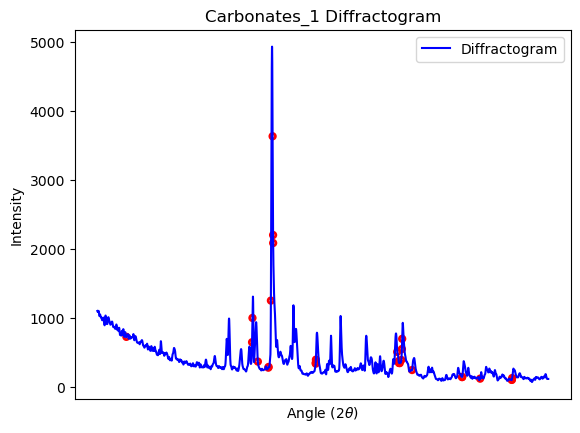

In [27]:
top_28_indices = feature_importance.argsort()[-28:][::-1]
X_top_N = X.iloc[:, top_28_indices]

xrd_data = xrd_df.iloc[0]

plt.plot(xrd_data, color='blue', label='Diffractogram')

encircle_x_values =X_top_N

circle_radius = 40

for encircle_x in encircle_x_values:
    encircle_y = xrd_data[encircle_x]
    
    circle = patches.Circle((encircle_x, encircle_y), circle_radius, edgecolor='red', facecolor='none', linewidth=2)
    plt.gca().add_patch(circle)

plt.title('Carbonates_1 Diffractogram')
plt.xticks([])
plt.xlabel('Angle (2$\\theta$)')
plt.ylabel('Intensity')
plt.legend()
plt.show()


In [ ]:
#------------------------------------------------------------------------------------------------------------------